In [23]:
import pandas as pd
import numpy as np
import time
import gc

from itertools import product
from dataProcessor import DataProcessor
from ARIMAStrategy import ARIMAStrategy
from backtestEngine import BacktestEngine

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

分析的日期范围: 2017-07-03 到 2019-11-07
总共天数: 644

一天的数据样本 (2017-07-03):
数据点数量: 759
时间范围: 2017-07-03 09:14:00 到 2017-07-03 23:44:00

价格统计信息:
               open          high           low         close
count    759.000000    759.000000    759.000000    759.000000
mean   25688.039526  25691.117260  25685.268775  25688.317523
std       34.236043     33.338881     35.061069     33.838209
min    25524.000000  25524.000000  25506.000000  25524.000000
25%    25676.000000  25678.000000  25674.000000  25676.000000
50%    25682.000000  25683.000000  25680.000000  25682.000000
75%    25701.500000  25706.000000  25697.000000  25702.000000
max    25763.000000  25768.000000  25759.000000  25764.000000


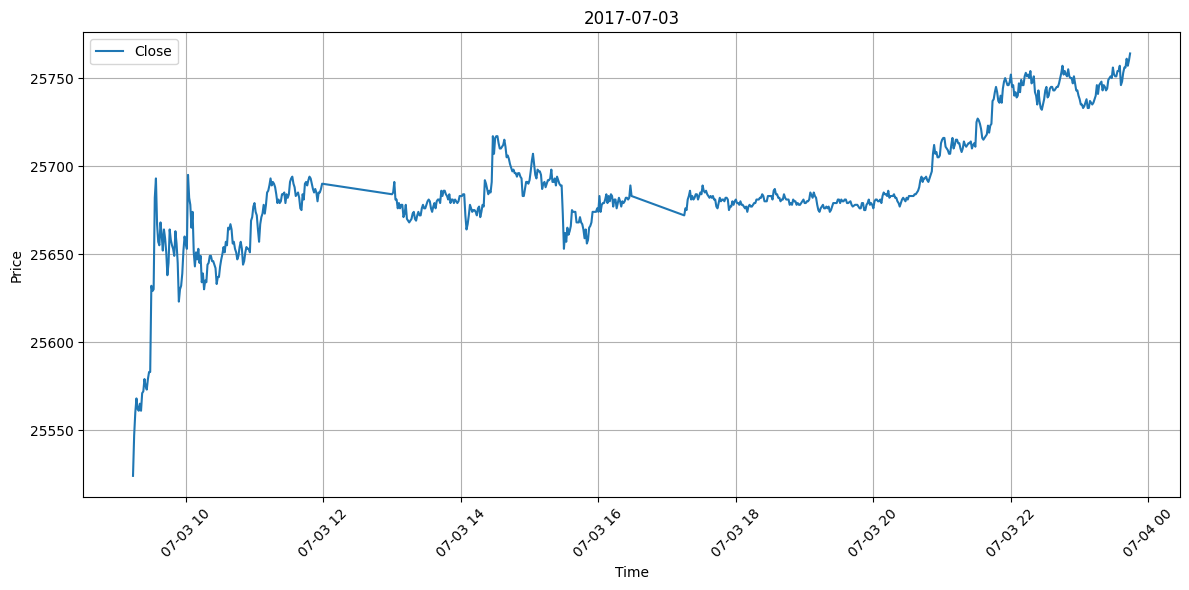

In [6]:
processor = DataProcessor(debug=False)
dates = processor.get_all_dates(is_train=True)
print(f"分析的日期范围: {dates[0]} 到 {dates[-1]}")
print(f"总共天数: {len(dates)}")

sample_date = dates[0]
daily_data = processor.get_daily_data(sample_date, is_train=True)

print(f"\n一天的数据样本 ({sample_date}):")
print(f"数据点数量: {len(daily_data)}")
print(f"时间范围: {daily_data['datetime'].min()} 到 {daily_data['datetime'].max()}")

print("\n价格统计信息:")
print(daily_data[['open', 'high', 'low', 'close']].describe())

plt.figure(figsize=(12, 6))
plt.plot(daily_data['datetime'], daily_data['close'], label='Close')
plt.title(f'{sample_date}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1. Data Analysis
### 1.1 ADF Analysis



开始测试原始序列的平稳性...
开始进行0阶差分的低内存ADF测试...
将644个交易日分为22批处理
批次进度：22/22 - 当前批次包含11460个数据点
总数据点数: 475072
批次进度：22/22 - 计算均值中...
序列均值: 28156.43735054897
批次进度：22/22 - 计算ADF统计量...

原始序列平稳性检验结果:
ADF统计量: 0.0019
p值: 0.9985
临界值:
	1%: -3.4300
	5%: -2.8600
	10%: -2.5700
序列不是平稳的


开始测试一阶差分的平稳性...
开始进行1阶差分的低内存ADF测试...
将644个交易日分为22批处理
批次进度：22/22 - 当前批次包含11460个数据点
总数据点数: 475072
批次进度：22/22 - 计算均值中...
序列均值: 0.0025251460706366404
批次进度：22/22 - 计算ADF统计量...

一阶差分平稳性检验结果:
ADF统计量: -1791094.0251
p值: 0.0000
临界值:
	1%: -3.4300
	5%: -2.8600
	10%: -2.5700
序列是平稳的

结论: 数据需要1阶差分才能达到平稳，建议ARIMA参数d=1


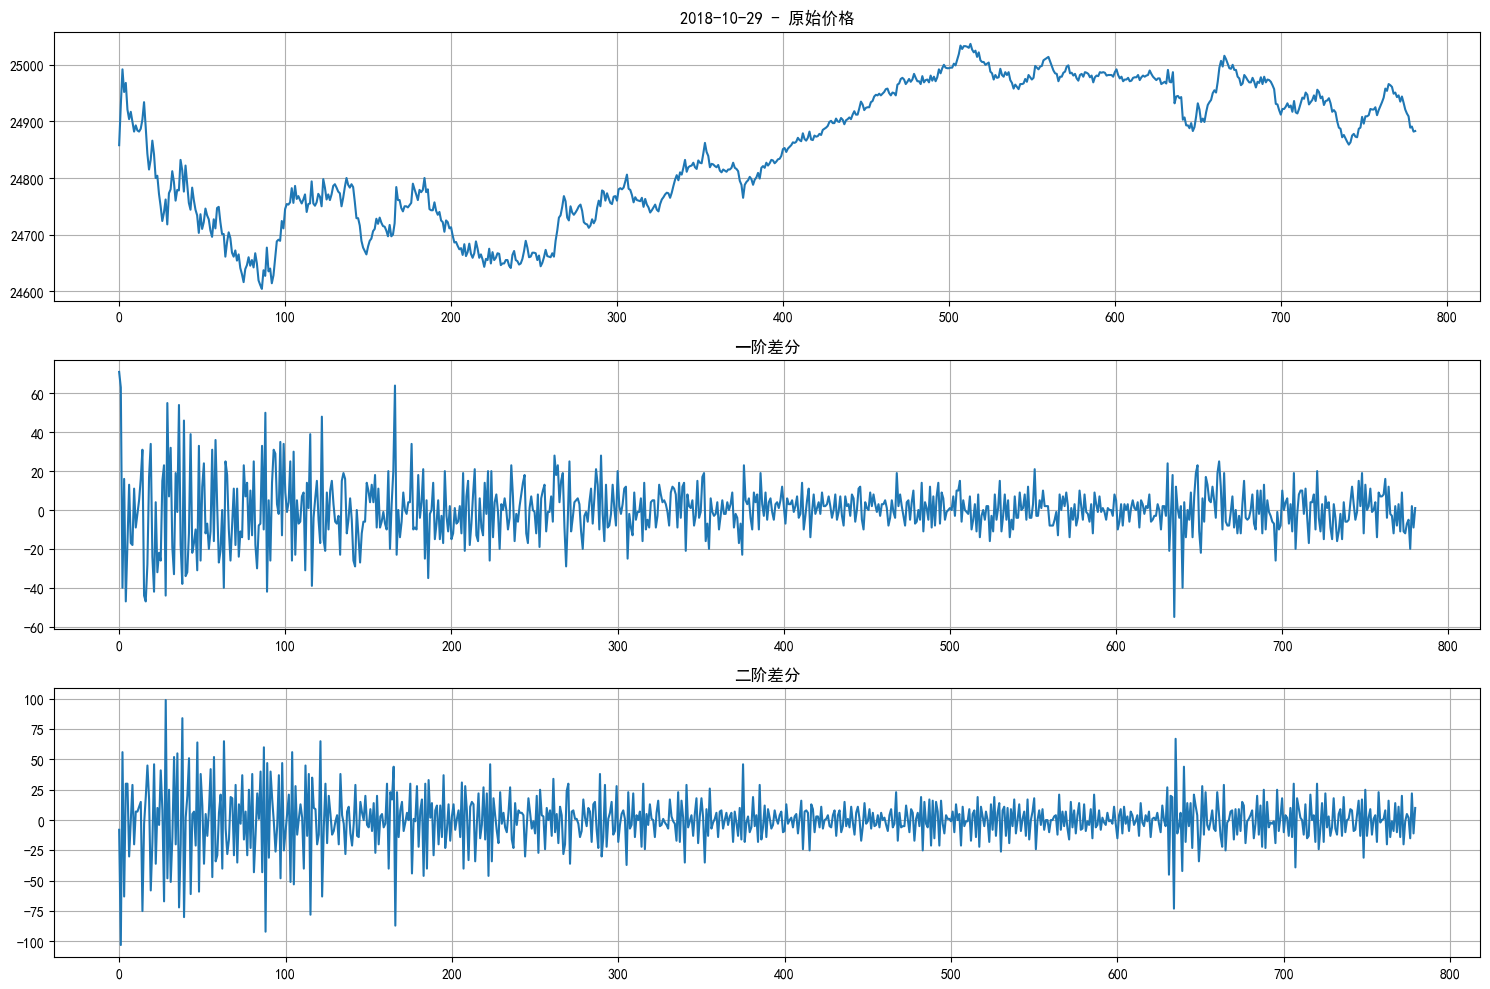

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import gc
import warnings
import sys
warnings.filterwarnings('ignore')

def low_memory_adf_test(processor, dates, column='close', diff_order=0, max_lag=10, batch_size=30):
    """
    低内存消耗的ADF测试实现
    Args:
        processor: 数据处理器
        dates: 日期列表
        column: 分析的列名
        diff_order: 差分阶数
        max_lag: 最大滞后期数
        batch_size: 每批处理的日期数
    
    Returns:
        adf_stat: ADF统计量
        p_value: p值
        critical_values: 临界值
    """
    print(f"开始进行{diff_order}阶差分的低内存ADF测试...")
    
    # 将日期分成批次
    date_batches = [dates[i:i+batch_size] for i in range(0, len(dates), batch_size)]
    print(f"将{len(dates)}个交易日分为{len(date_batches)}批处理")
    
    # 1. 准备差分序列数据
    # 由于无法一次加载所有数据，我们使用流式处理方法
    
    # 首先统计时间序列的总长度
    total_length = 0
    for batch_idx, batch_dates in enumerate(date_batches):
        batch_length = 0
        for date in batch_dates:
            daily_data = processor.get_daily_data(date, is_train=True)
            if not daily_data.empty:
                batch_length += len(daily_data)
        total_length += batch_length
        sys.stdout.write(f"\r批次进度：{batch_idx+1}/{len(date_batches)} - 当前批次包含{batch_length}个数据点")
        sys.stdout.flush()
    
    print(f"\n总数据点数: {total_length}")
    
    # 2. 计算差分序列的基本统计量
    # 我们不存储完整序列，而是累积计算统计量
    
    # 计算均值 - 需要两遍扫描
    sum_values = 0
    count_values = 0
    
    # 第一遍：计算均值
    for batch_idx, batch_dates in enumerate(date_batches):
        sys.stdout.write(f"\r批次进度：{batch_idx+1}/{len(date_batches)} - 计算均值中...")
        sys.stdout.flush()
        
        # 处理该批次的所有日期
        for date in batch_dates:
            daily_data = processor.get_daily_data(date, is_train=True)
            if daily_data.empty:
                continue
                
            values = daily_data[column].values
            
            # 根据差分阶数处理
            if diff_order >= 1:
                values = np.diff(values, n=diff_order)
            
            sum_values += np.sum(values)
            count_values += len(values)
            
        # 释放内存
        gc.collect()
    
    print()  # 换行
    if count_values == 0:
        raise ValueError("没有有效数据点")
        
    mean_value = sum_values / count_values
    print(f"序列均值: {mean_value}")
    
    # 3. 手动实现ADF测试的核心部分
    # 对于ADF测试，我们需要计算:
    # 1) Yt - Yt-1 (差分)
    # 2) Yt-1 - 均值
    # 3) 滞后差分项
    
    # 初始化统计量累积变量
    sum_y_diff_sq = 0  # 差分项平方和
    sum_y_lagged_sq = 0  # 滞后项平方和
    sum_cross_product = 0  # 交叉乘积和
    n_observations = 0  # 有效观测数
    
    # 保存最后一批值用于计算初始滞后项
    last_values = []
    
    # 第二遍：计算ADF统计量
    for batch_idx, batch_dates in enumerate(date_batches):
        sys.stdout.write(f"\r批次进度：{batch_idx+1}/{len(date_batches)} - 计算ADF统计量...")
        sys.stdout.flush()
        
        batch_values = []
        
        # 收集批次数据
        for date in batch_dates:
            daily_data = processor.get_daily_data(date, is_train=True)
            if daily_data.empty:
                continue
                
            batch_values.extend(daily_data[column].values.tolist())  # 确保是列表而不是numpy数组
        
        # 转换为numpy数组以便处理
        batch_values = np.array(batch_values)
        
        # 如果需要，添加上一批次的最后几个值
        if len(last_values) > 0 and diff_order > 0:
            batch_values = np.concatenate([last_values[-diff_order:], batch_values])
        
        # 保存当前批次的最后几个值
        last_values = batch_values[-max_lag-diff_order-1:].copy() if len(batch_values) > max_lag+diff_order+1 else batch_values.copy()
        
        # 计算差分
        if diff_order >= 1:
            batch_diff = np.diff(batch_values, n=diff_order)
        else:
            batch_diff = batch_values
            
        # 我们需要Yt-1值（差分前的滞后1期值）
        if len(batch_values) > diff_order + 1:
            batch_lagged = batch_values[diff_order:-1]  # Yt-1
            batch_diff = batch_diff[1:]  # 对应的Yt - Yt-1
            
            # 确保长度匹配
            min_len = min(len(batch_lagged), len(batch_diff))
            batch_lagged = batch_lagged[:min_len]
            batch_diff = batch_diff[:min_len]
            
            # 计算ADF统计量所需的部分和
            batch_lagged_centered = batch_lagged - mean_value
            sum_y_diff_sq += np.sum(batch_diff ** 2)
            sum_y_lagged_sq += np.sum(batch_lagged_centered ** 2)
            sum_cross_product += np.sum(batch_diff * batch_lagged_centered)
            n_observations += min_len
        
        # 释放内存
        del batch_values, batch_diff
        if 'batch_lagged' in locals():
            del batch_lagged, batch_lagged_centered
        gc.collect()
    
    print()  # 换行
    # 4. 计算ADF统计量
    if n_observations < 20:  # 确保有足够的观测值
        raise ValueError("有效观测值太少，无法进行ADF测试")
    
    # 计算回归系数 (beta)
    beta = sum_cross_product / sum_y_lagged_sq
    
    # 计算标准误差
    se = np.sqrt((sum_y_diff_sq - beta * sum_cross_product) / (n_observations - 1) / sum_y_lagged_sq)
    
    # 计算ADF统计量
    adf_stat = (beta - 1) / se
    
    # 使用Dickey-Fuller分布计算p值
    # 注意：这是一个近似值，实际上应该使用更复杂的方法, 但为了简化，我们使用t分布作为近似
    p_value = stats.t.sf(abs(adf_stat), n_observations - 1) * 2
    
    # 临界值 (近似值)
    critical_values = {
        '1%': -3.43,
        '5%': -2.86,
        '10%': -2.57
    }
    
    return adf_stat, p_value, critical_values

    
# 按顺序测试不同阶数的差分
for diff_order in [0, 1, 2]:
    try:
        diff_name = {0: '原始序列', 1: '一阶差分', 2: '二阶差分'}.get(diff_order, f'{diff_order}阶差分')
        print(f"\n\n开始测试{diff_name}的平稳性...")
        
        adf_stat, p_value, critical_values = low_memory_adf_test(
            processor, dates, diff_order=diff_order
        )
        
        # 输出结果
        print(f"\n{diff_name}平稳性检验结果:")
        print(f'ADF统计量: {adf_stat:.4f}')
        print(f'p值: {p_value:.4f}')
        print('临界值:')
        for key, value in critical_values.items():
            print(f'\t{key}: {value:.4f}')
        
        is_stationary = p_value <= 0.05
        print(f"序列{'是' if is_stationary else '不是'}平稳的")
        
        # 如果序列已经平稳，可以停止测试更高阶差分
        if is_stationary:
            print(f"\n结论: 数据需要{diff_order}阶差分才能达到平稳，建议ARIMA参数d={diff_order}")
            break
            
    except Exception as e:
        print(f"测试{diff_order}阶差分时出错: {str(e)}")
else:
    print("\n警告: 在测试的所有差分阶数中，序列都不平稳")


# 确保sample_days变量已定义，如果未定义则设置默认值
if 'sample_days' not in locals():
    sample_days = 2

if len(dates) > sample_days:
    sample_dates = np.random.choice(dates, sample_days, replace=False)
else:
    sample_dates = dates

for date in sample_dates:
    daily_data = processor.get_daily_data(date, is_train=True)
    if daily_data.empty:
        continue
    
    values = daily_data['close'].values
    
    # 计算差分
    diff1 = np.diff(values) if len(values) > 1 else []
    diff2 = np.diff(diff1) if len(diff1) > 1 else []
    
    # 绘图
    plt.figure(figsize=(15, 10))
    
    plt.subplot(311)
    plt.plot(values)
    plt.title(f'{date} - 原始价格')
    plt.grid(True)
    
    plt.subplot(312)
    plt.plot(diff1)
    plt.title('一阶差分')
    plt.grid(True)
    
    plt.subplot(313)
    plt.plot(diff2)
    plt.title('二阶差分')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 只显示几个样本日
    if sample_days <= 2:
        break

#### 遇到的问题：
传统的ADF测试通常要求将整个时间序列加载到内存中，这在处理高频交易数据或长时间跨度的金融数据时会导致内存溢出。 

解决方案：  
- 批量流式处理: 将大型数据集分成较小的批次进行处理，避免一次性加载全部数据到内存中
- 统计量增量计算: 不存储完整序列，而是通过多次扫描累积计算统计量
- 滑动窗口技术: 通过保留批次间的必要数据连接点(last_values)实现了跨批次的差分和滞后计算
- 内存管理优化: 及时释放不需要的变量并调用垃圾收集

该方法可以用于流式处理ADF检验

### 1.2 ACF & PACF Analysis

正在收集数据...
共收集了 475072 个价格数据点
一阶差分后的数据点数: 475071


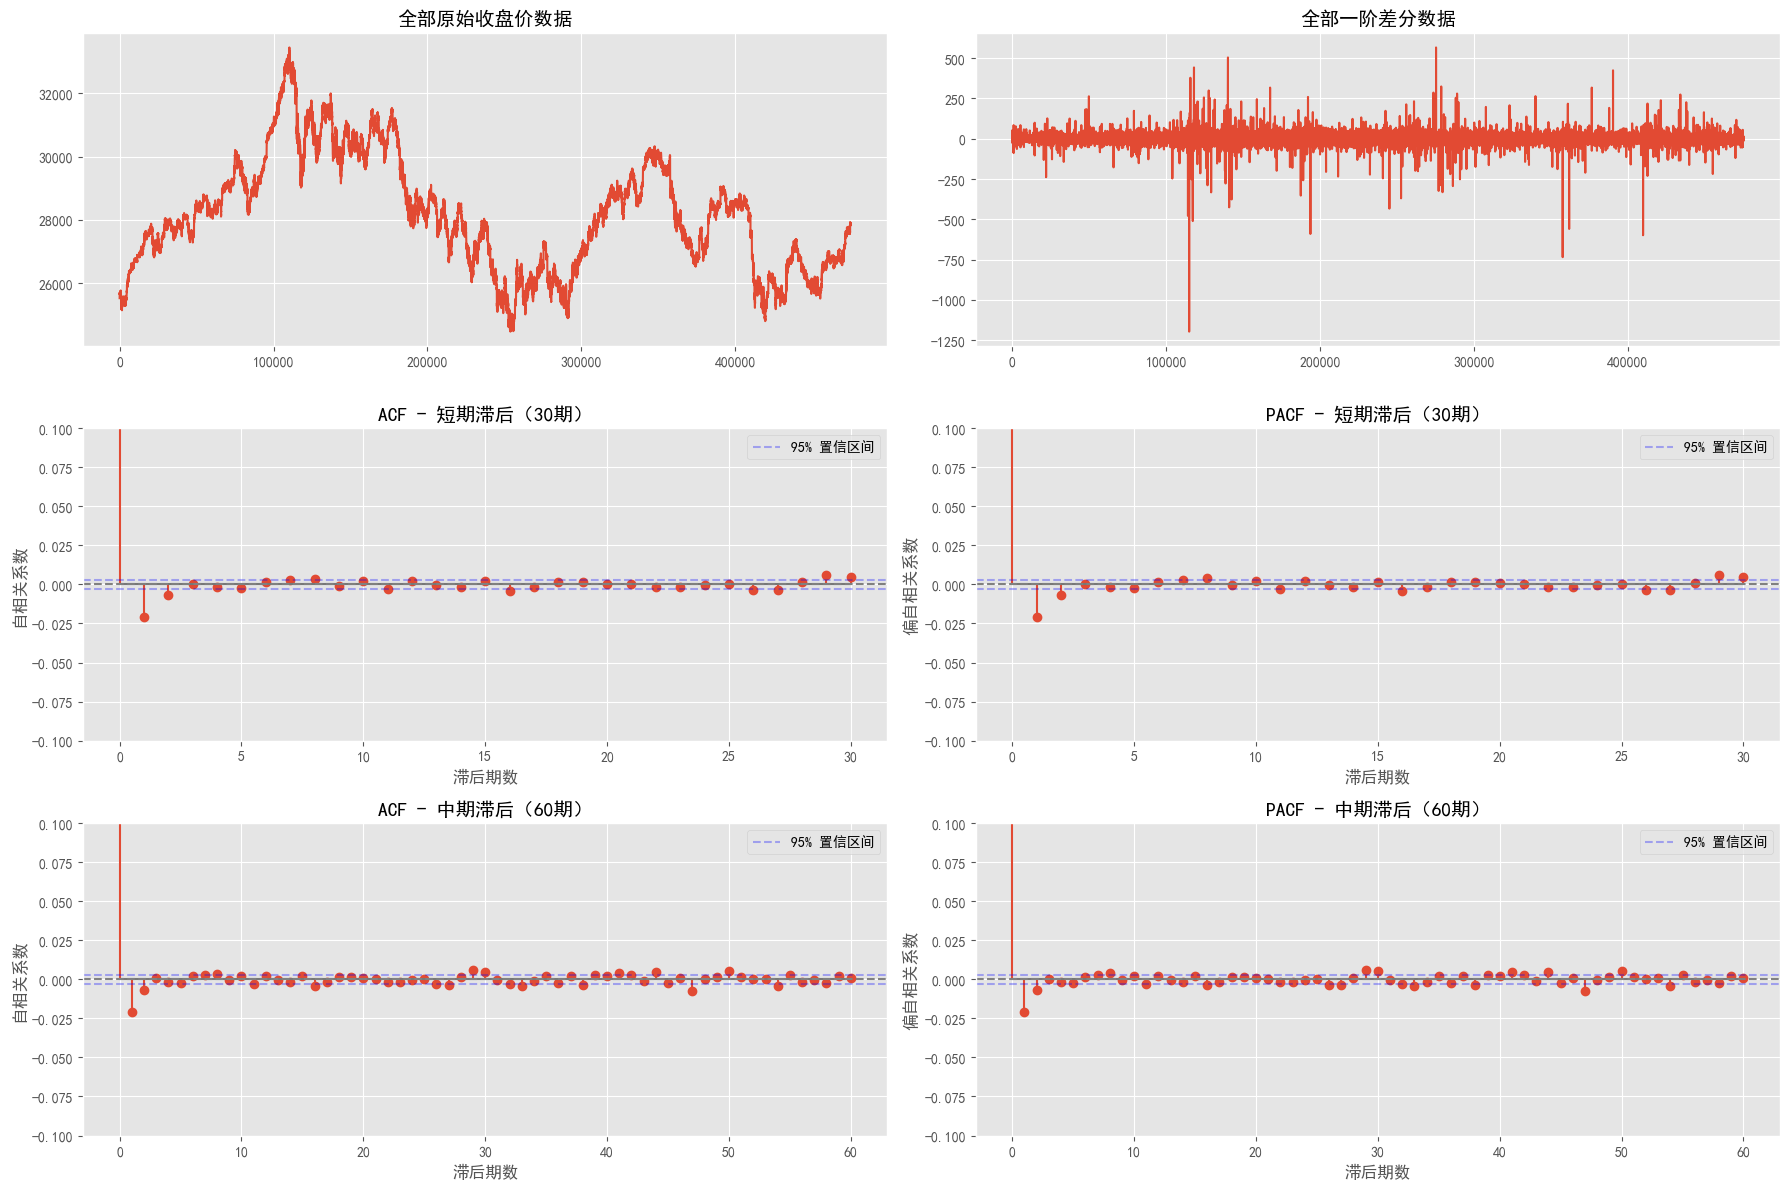

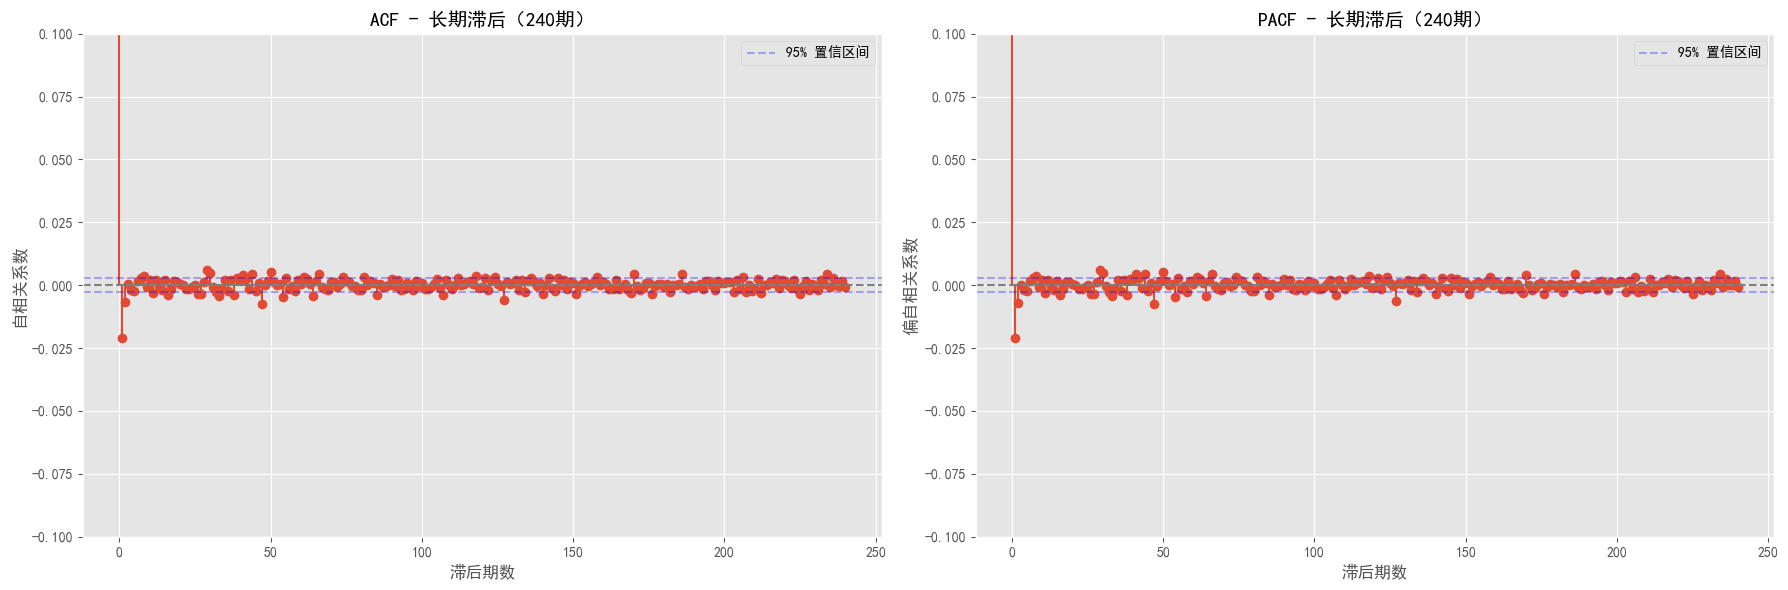


尝试聚合数据为5分钟K线...
聚合后的数据点数: 95014
聚合后的差分数据点数: 95013


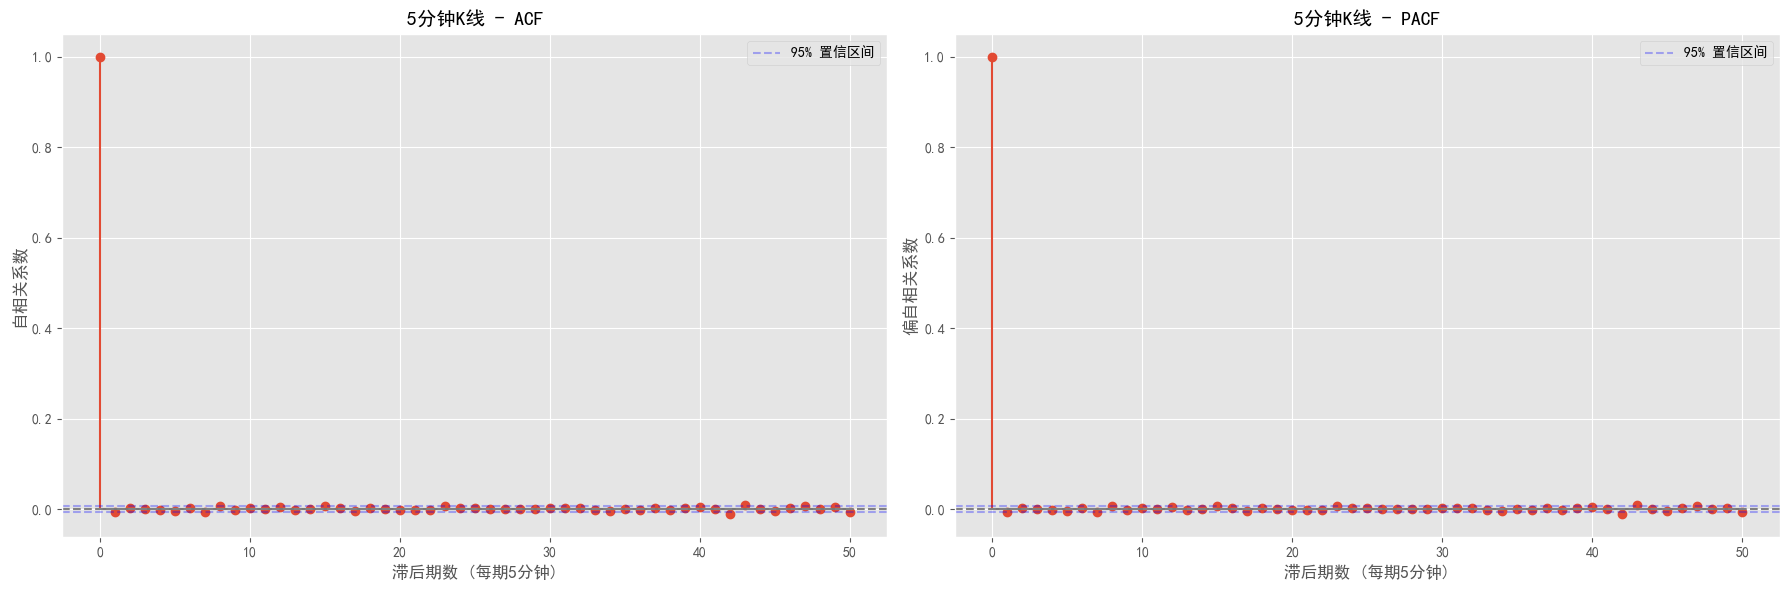


====== ACF和PACF图形分析 ======

原始分钟数据分析:
ACF 显著滞后期: [1, 2, 8, 11, 16, 26, 27, 29, 30, 32]...
PACF 显著滞后期: [1, 2, 8, 11, 16, 26, 27, 29, 30, 32]...
ACF既不明显截尾也不明显拖尾
PACF既不明显截尾也不明显拖尾

5分钟聚合数据分析:
ACF 显著滞后期: [8, 15, 23, 42, 43, 50]
PACF 显著滞后期: [8, 15, 23, 42, 43, 50]
聚合数据ACF既不明显截尾也不明显拖尾
聚合数据PACF既不明显截尾也不明显拖尾

====== ARIMA模型参数建议 ======
ACF和PACF都有显著滞后期，建议ARIMA(55,1,55)模型

对于5分钟聚合数据:
聚合数据ACF和PACF都有显著滞后期，建议ARIMA(50,1,50)模型


In [26]:
# 初始化数据处理器
processor = DataProcessor(debug=False)
dates = processor.get_all_dates(is_train=True)

# 收集所有数据以分析整体时间序列
all_prices = []

# 获取所有训练日期的收盘价
print("正在收集数据...")
for date in dates:
    daily_data = processor.get_daily_data(date, is_train=True)
    if not daily_data.empty:
        all_prices.extend(daily_data['close'].values)

# 转换为numpy数组
all_prices = np.array(all_prices)
print(f"共收集了 {len(all_prices)} 个价格数据点")

# 计算一阶差分（d=1已确认为平稳）
price_diff = np.diff(all_prices)
print(f"一阶差分后的数据点数: {len(price_diff)}")

# 设置不同滞后期以捕捉不同时间尺度的模式
short_lags = 30  # 短期模式（约30分钟）
medium_lags = 60  # 中期模式（约1小时）
long_lags = 240  # 长期模式（约4小时）

# 创建多个图形来比较不同滞后期的ACF和PACF
plt.figure(figsize=(18, 12))

# 绘制原始数据和差分数据
plt.subplot(321)
plt.plot(all_prices)
plt.title('全部原始收盘价数据', fontsize=14)
plt.grid(True)

plt.subplot(322)
plt.plot(price_diff)
plt.title('全部一阶差分数据', fontsize=14)
plt.grid(True)

# 放大显示ACF和PACF的y轴范围，以便更清晰地看到微小变化
y_min = -0.1
y_max = 0.1

# 短期滞后的ACF
plt.subplot(323)
acf_values_short = acf(price_diff, nlags=short_lags, fft=True)
plt.stem(range(len(acf_values_short)), acf_values_short)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3, label='95% 置信区间')
plt.axhline(y=-1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3)
plt.title(f'ACF - 短期滞后（{short_lags}期）', fontsize=14)
plt.ylim(y_min, y_max)  # 设置y轴范围以放大显示
plt.grid(True)
plt.xlabel('滞后期数')
plt.ylabel('自相关系数')
plt.legend()

# 短期滞后的PACF
plt.subplot(324)
pacf_values_short = pacf(price_diff, nlags=short_lags)
plt.stem(range(len(pacf_values_short)), pacf_values_short)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3, label='95% 置信区间')
plt.axhline(y=-1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3)
plt.title(f'PACF - 短期滞后（{short_lags}期）', fontsize=14)
plt.ylim(y_min, y_max)  # 设置y轴范围以放大显示
plt.grid(True)
plt.xlabel('滞后期数')
plt.ylabel('偏自相关系数')
plt.legend()

# 中期滞后的ACF
plt.subplot(325)
acf_values_medium = acf(price_diff, nlags=medium_lags, fft=True)
plt.stem(range(len(acf_values_medium)), acf_values_medium)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3, label='95% 置信区间')
plt.axhline(y=-1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3)
plt.title(f'ACF - 中期滞后（{medium_lags}期）', fontsize=14)
plt.ylim(y_min, y_max)  # 设置y轴范围以放大显示
plt.grid(True)
plt.xlabel('滞后期数')
plt.ylabel('自相关系数')
plt.legend()

# 中期滞后的PACF
plt.subplot(326)
pacf_values_medium = pacf(price_diff, nlags=medium_lags)
plt.stem(range(len(pacf_values_medium)), pacf_values_medium)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3, label='95% 置信区间')
plt.axhline(y=-1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3)
plt.title(f'PACF - 中期滞后（{medium_lags}期）', fontsize=14)
plt.ylim(y_min, y_max)  # 设置y轴范围以放大显示
plt.grid(True)
plt.xlabel('滞后期数')
plt.ylabel('偏自相关系数')
plt.legend()

plt.tight_layout()
plt.show()

# 添加长期滞后的图形
plt.figure(figsize=(18, 6))

# 长期滞后的ACF
plt.subplot(121)
acf_values_long = acf(price_diff, nlags=long_lags, fft=True)
plt.stem(range(len(acf_values_long)), acf_values_long)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3, label='95% 置信区间')
plt.axhline(y=-1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3)
plt.title(f'ACF - 长期滞后（{long_lags}期）', fontsize=14)
plt.ylim(y_min, y_max)  # 设置y轴范围以放大显示
plt.grid(True)
plt.xlabel('滞后期数')
plt.ylabel('自相关系数')
plt.legend()

# 长期滞后的PACF
plt.subplot(122)
pacf_values_long = pacf(price_diff, nlags=long_lags)
plt.stem(range(len(pacf_values_long)), pacf_values_long)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3, label='95% 置信区间')
plt.axhline(y=-1.96/np.sqrt(len(price_diff)), linestyle='--', color='blue', alpha=0.3)
plt.title(f'PACF - 长期滞后（{long_lags}期）', fontsize=14)
plt.ylim(y_min, y_max)  # 设置y轴范围以放大显示
plt.grid(True)
plt.xlabel('滞后期数')
plt.ylabel('偏自相关系数')
plt.legend()

plt.tight_layout()
plt.show()

# 对数据进行聚合处理，转换为5分钟K线
print("\n尝试聚合数据为5分钟K线...")

# 假设每分钟一个数据点，聚合为5分钟
agg_factor = 5
agg_prices = []
for i in range(0, len(all_prices), agg_factor):
    if i + agg_factor <= len(all_prices):
        agg_prices.append(all_prices[i + agg_factor - 1])  # 取每5分钟的最后一个价格作为收盘价

agg_prices = np.array(agg_prices)
agg_diff = np.diff(agg_prices)

print(f"聚合后的数据点数: {len(agg_prices)}")
print(f"聚合后的差分数据点数: {len(agg_diff)}")

# 为聚合数据绘制ACF和PACF
plt.figure(figsize=(18, 6))

# 聚合数据的ACF
plt.subplot(121)
agg_acf_values = acf(agg_diff, nlags=50, fft=True)  # 50个5分钟周期相当于原来的250分钟
plt.stem(range(len(agg_acf_values)), agg_acf_values)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(agg_diff)), linestyle='--', color='blue', alpha=0.3, label='95% 置信区间')
plt.axhline(y=-1.96/np.sqrt(len(agg_diff)), linestyle='--', color='blue', alpha=0.3)
plt.title('5分钟K线 - ACF', fontsize=14)
plt.grid(True)
plt.xlabel('滞后期数 (每期5分钟)')
plt.ylabel('自相关系数')
plt.legend()

# 聚合数据的PACF
plt.subplot(122)
agg_pacf_values = pacf(agg_diff, nlags=50)
plt.stem(range(len(agg_pacf_values)), agg_pacf_values)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(agg_diff)), linestyle='--', color='blue', alpha=0.3, label='95% 置信区间')
plt.axhline(y=-1.96/np.sqrt(len(agg_diff)), linestyle='--', color='blue', alpha=0.3)
plt.title('5分钟K线 - PACF', fontsize=14)
plt.grid(True)
plt.xlabel('滞后期数 (每期5分钟)')
plt.ylabel('偏自相关系数')
plt.legend()

plt.tight_layout()
plt.show()

# 分析ACF和PACF的特征
print("\n====== ACF和PACF图形分析 ======")

# 检查原始分钟数据的ACF和PACF特征
acf_significance = 1.96/np.sqrt(len(price_diff))
pacf_significance = 1.96/np.sqrt(len(price_diff))

# 计算显著滞后期
significant_acf_lags = [i for i in range(1, len(acf_values_medium)) if abs(acf_values_medium[i]) > acf_significance]
significant_pacf_lags = [i for i in range(1, len(pacf_values_medium)) if abs(pacf_values_medium[i]) > pacf_significance]

print("\n原始分钟数据分析:")
print(f"ACF 显著滞后期: {significant_acf_lags[:10]}{'...' if len(significant_acf_lags) > 10 else ''}")
print(f"PACF 显著滞后期: {significant_pacf_lags[:10]}{'...' if len(significant_pacf_lags) > 10 else ''}")

# 检查ACF和PACF是否有明显的截尾或拖尾特征
if len(significant_acf_lags) == 0:
    print("ACF没有显著的滞后期，可能是白噪声")
elif max(significant_acf_lags) <= 3:
    print(f"ACF在滞后{max(significant_acf_lags)}期后截尾")
else:
    # 检查是否有连续的显著滞后期
    consecutive = True
    for i in range(1, 4):
        if i not in significant_acf_lags:
            consecutive = False
            break
    if consecutive:
        print("ACF呈现拖尾特征")
    else:
        print("ACF既不明显截尾也不明显拖尾")

if len(significant_pacf_lags) == 0:
    print("PACF没有显著的滞后期，可能是白噪声")
elif max(significant_pacf_lags) <= 3:
    print(f"PACF在滞后{max(significant_pacf_lags)}期后截尾")
else:
    # 检查是否有连续的显著滞后期
    consecutive = True
    for i in range(1, 4):
        if i not in significant_pacf_lags:
            consecutive = False
            break
    if consecutive:
        print("PACF呈现拖尾特征")
    else:
        print("PACF既不明显截尾也不明显拖尾")

# 检查聚合数据的ACF和PACF特征
agg_acf_significance = 1.96/np.sqrt(len(agg_diff))
agg_pacf_significance = 1.96/np.sqrt(len(agg_diff))

# 计算聚合数据的显著滞后期
agg_significant_acf_lags = [i for i in range(1, len(agg_acf_values)) if abs(agg_acf_values[i]) > agg_acf_significance]
agg_significant_pacf_lags = [i for i in range(1, len(agg_pacf_values)) if abs(agg_pacf_values[i]) > agg_pacf_significance]

print("\n5分钟聚合数据分析:")
print(f"ACF 显著滞后期: {agg_significant_acf_lags[:10]}{'...' if len(agg_significant_acf_lags) > 10 else ''}")
print(f"PACF 显著滞后期: {agg_significant_pacf_lags[:10]}{'...' if len(agg_significant_pacf_lags) > 10 else ''}")

# 检查聚合数据的ACF和PACF是否有明显的截尾或拖尾特征
if len(agg_significant_acf_lags) == 0:
    print("聚合数据ACF没有显著的滞后期，可能是白噪声")
elif max(agg_significant_acf_lags) <= 3:
    print(f"聚合数据ACF在滞后{max(agg_significant_acf_lags)}期后截尾")
else:
    consecutive = True
    for i in range(1, 4):
        if i not in agg_significant_acf_lags:
            consecutive = False
            break
    if consecutive:
        print("聚合数据ACF呈现拖尾特征")
    else:
        print("聚合数据ACF既不明显截尾也不明显拖尾")

if len(agg_significant_pacf_lags) == 0:
    print("聚合数据PACF没有显著的滞后期，可能是白噪声")
elif max(agg_significant_pacf_lags) <= 3:
    print(f"聚合数据PACF在滞后{max(agg_significant_pacf_lags)}期后截尾")
else:
    consecutive = True
    for i in range(1, 4):
        if i not in agg_significant_pacf_lags:
            consecutive = False
            break
    if consecutive:
        print("聚合数据PACF呈现拖尾特征")
    else:
        print("聚合数据PACF既不明显截尾也不明显拖尾")

# 根据分析给出模型建议
print("\n====== ARIMA模型参数建议 ======")
if len(significant_acf_lags) == 0 and len(significant_pacf_lags) == 0:
    print("原始分钟数据可能是白噪声，建议ARIMA(0,1,0)模型")
elif len(significant_pacf_lags) > 0 and (len(significant_acf_lags) == 0 or max(significant_pacf_lags) < max(significant_acf_lags)):
    p = max(significant_pacf_lags)
    print(f"PACF在滞后{p}期显著，建议ARIMA({p},1,0)模型")
elif len(significant_acf_lags) > 0 and (len(significant_pacf_lags) == 0 or max(significant_acf_lags) < max(significant_pacf_lags)):
    q = max(significant_acf_lags)
    print(f"ACF在滞后{q}期显著，建议ARIMA(0,1,{q})模型")
else:
    p = max(significant_pacf_lags)
    q = max(significant_acf_lags)
    print(f"ACF和PACF都有显著滞后期，建议ARIMA({p},1,{q})模型")

print("\n对于5分钟聚合数据:")
if len(agg_significant_acf_lags) == 0 and len(agg_significant_pacf_lags) == 0:
    print("聚合数据可能是白噪声，建议ARIMA(0,1,0)模型")
elif len(agg_significant_pacf_lags) > 0 and (len(agg_significant_acf_lags) == 0 or max(agg_significant_pacf_lags) < max(agg_significant_acf_lags)):
    p = max(agg_significant_pacf_lags)
    print(f"聚合数据PACF在滞后{p}期显著，建议ARIMA({p},1,0)模型")
elif len(agg_significant_acf_lags) > 0 and (len(agg_significant_pacf_lags) == 0 or max(agg_significant_acf_lags) < max(agg_significant_pacf_lags)):
    q = max(agg_significant_acf_lags)
    print(f"聚合数据ACF在滞后{q}期显著，建议ARIMA(0,1,{q})模型")
else:
    p = max(agg_significant_pacf_lags)
    q = max(agg_significant_acf_lags)
    print(f"聚合数据ACF和PACF都有显著滞后期，建议ARIMA({p},1,{q})模型")

### 分析结果解读
1. 显著滞后期的分散性：滞后期是分散的(1, 2, 8, 11, 16...)而非连续的, 这表明数据中可能存在某种周期性，而非典型的AR或MA过程. 可能表明存在市场微观结构效应
2. 金融高频数据通常具有微弱且复杂的自相关结构, "既不明显截尾也不明显拖尾"的结果很常见

# 2. HAR + ARIMA

# 3. Risk Parameters Optimization